In [2]:
import ROOT as r
import pandas as pd
import numpy as np
pd.set_option('display.max_colwidth', None)

import uproot
import hist
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.CMS)

In [3]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/output/run2/sig.root")
df = df.Filter("isElectron").Filter("sample_year == \"2017\"")

In [4]:
h1 = df.Filter("passCut1 == 1 & passCut2 == 1").Histo1D(("", "", 4, np.array([35, 40, 50, 100, 200], "d")), "GLepton_pt")
h2 = df.Filter("passCut2 == 1").Histo1D(("", "", 4, np.array([35, 40, 50, 100, 200], "d")), "GLepton_pt")

h3 = df.Filter("passCut1 == 1 & passCut2 == 1").Histo1D(("", "", 4, np.array([35, 40, 50, 100, 200], "d")), "GLepton_pt", "weight")
h4 = df.Filter("passCut2 == 1").Histo1D(("", "", 4, np.array([35, 40, 50, 100, 200], "d")), "GLepton_pt", "weight")

h1 = h1.GetValue()
h2 = h2.GetValue()
h3 = h3.GetValue()
h4 = h4.GetValue()

h1.Sumw2()
h2.Sumw2()
h3.Sumw2()
h4.Sumw2()

h1.Divide(h2)
h3.Divide(h4)

True

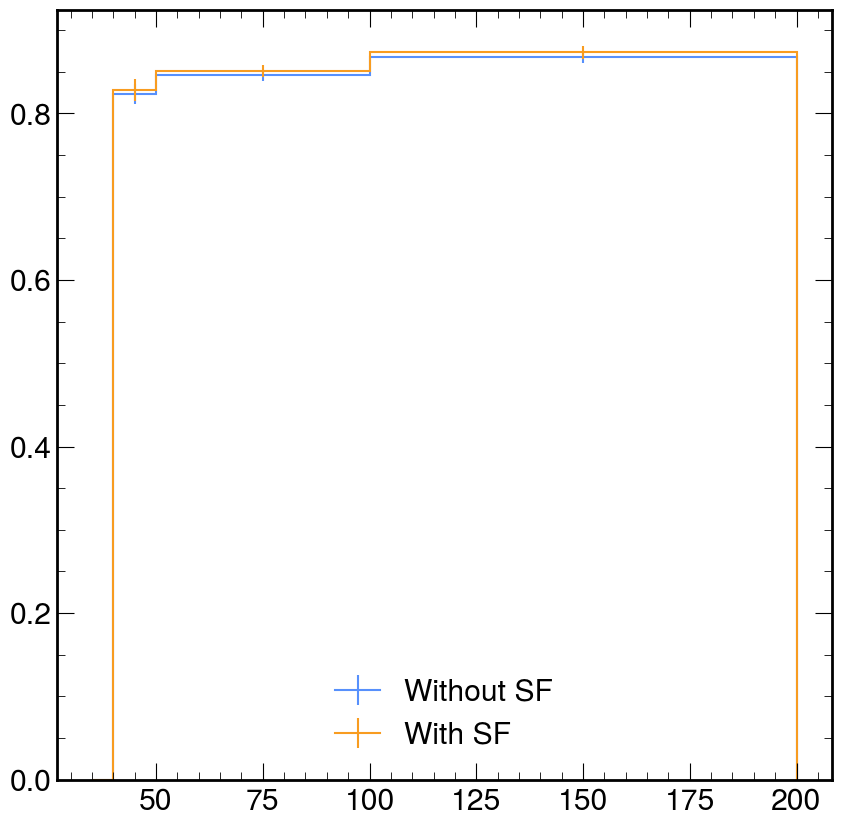

In [6]:
fig, ax = plt.subplots()

hep.histplot(h1, label="Without SF", ax=ax)
hep.histplot(h3, label="With SF", ax=ax)

ax.legend()

In [12]:
def get_sig_hist(df, eta1, eta2):
    fil = f"GElectron_etaSC[0] > {eta1} && GElectron_etaSC[0] < {eta2}"
    h3 = df.Filter("passCut1 == 1 & passCut2 == 1").Filter(fil).Histo1D(("", "", 4, np.array([35, 40, 50, 100, 200], "d")), "GLepton_pt", "weight")
    h4 = df.Filter("passCut2 == 1").Filter(fil).Histo1D(("", "", 4, np.array([35, 40, 50, 100, 200], "d")), "GLepton_pt", "weight")

    h3 = h3.GetValue()
    h4 = h4.GetValue()

    h3.Sumw2()
    h4.Sumw2()

    h3.Divide(h4)
    return h3

In [9]:
with uproot.open("/home/users/aaarora/phys/analysis/vbs-1lep/junk/root_sf/elec/electron_hlt_sfs_2017.root") as f:
    hlt_sf_data = f["EGamma_EffData2D"].to_hist()
    hlt_sf_mc = f["EGamma_EffMC2D"].to_hist()

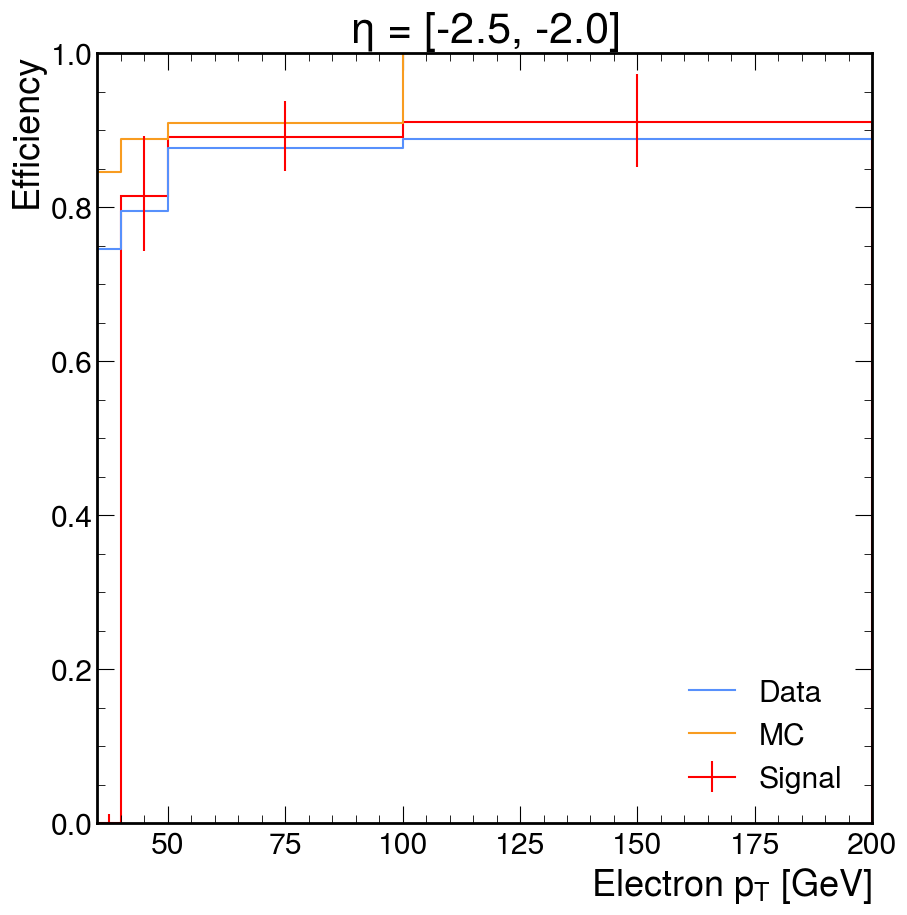

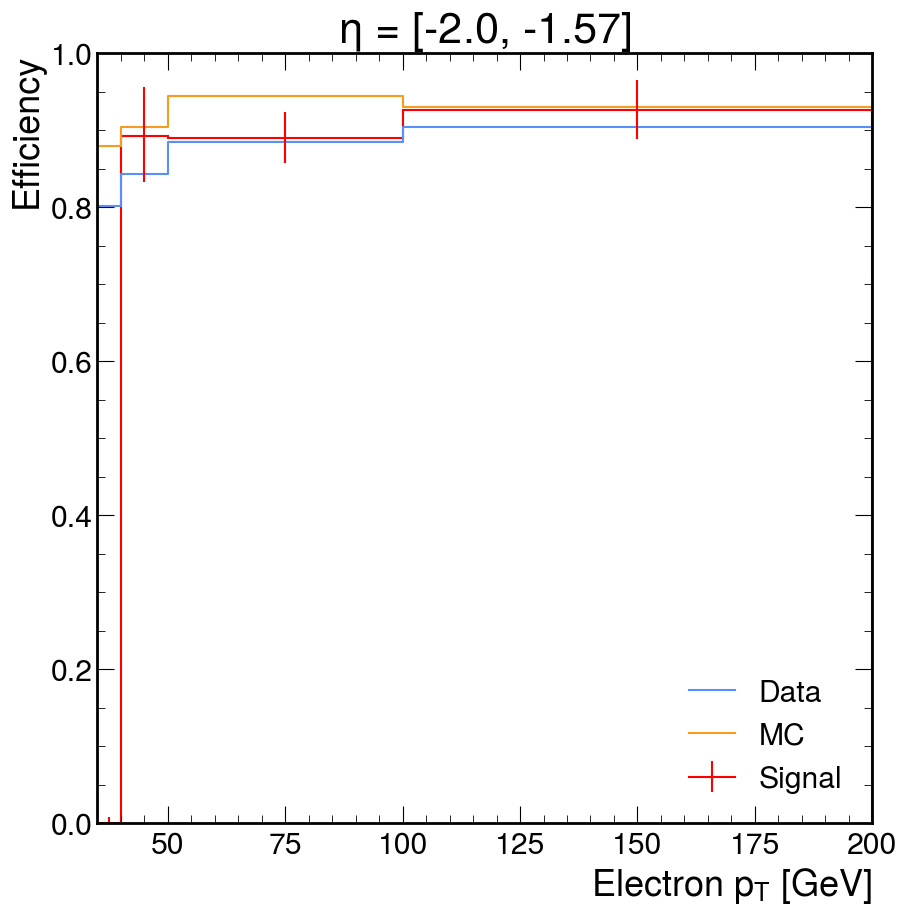

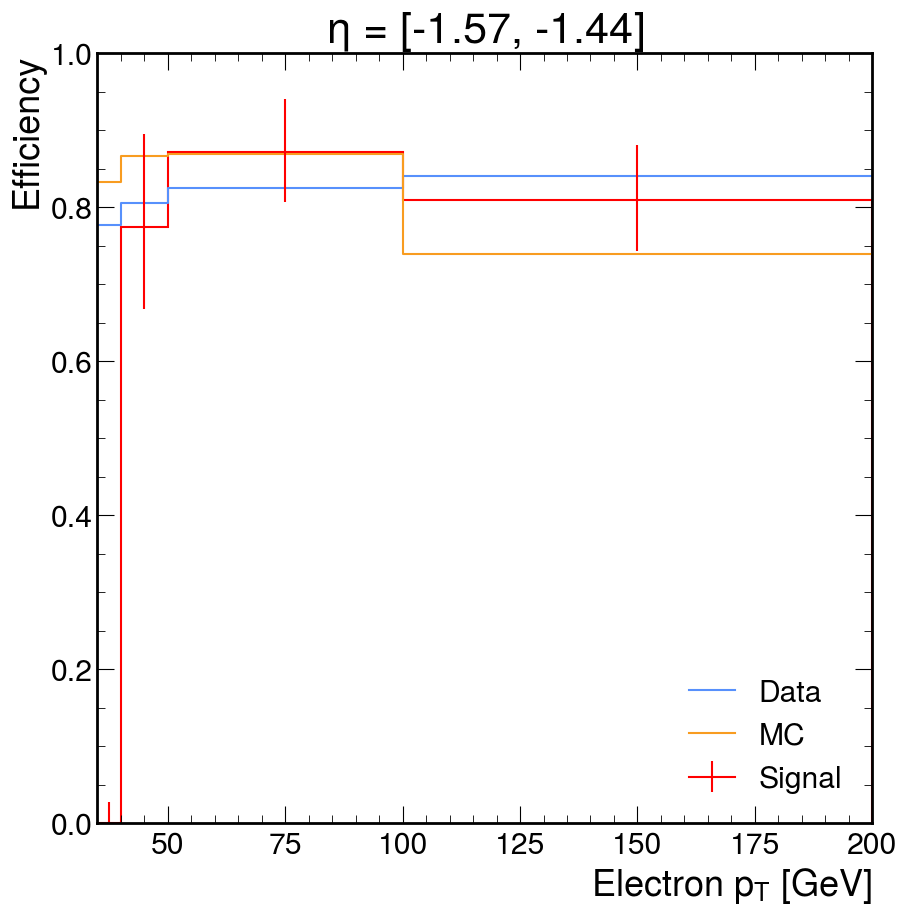

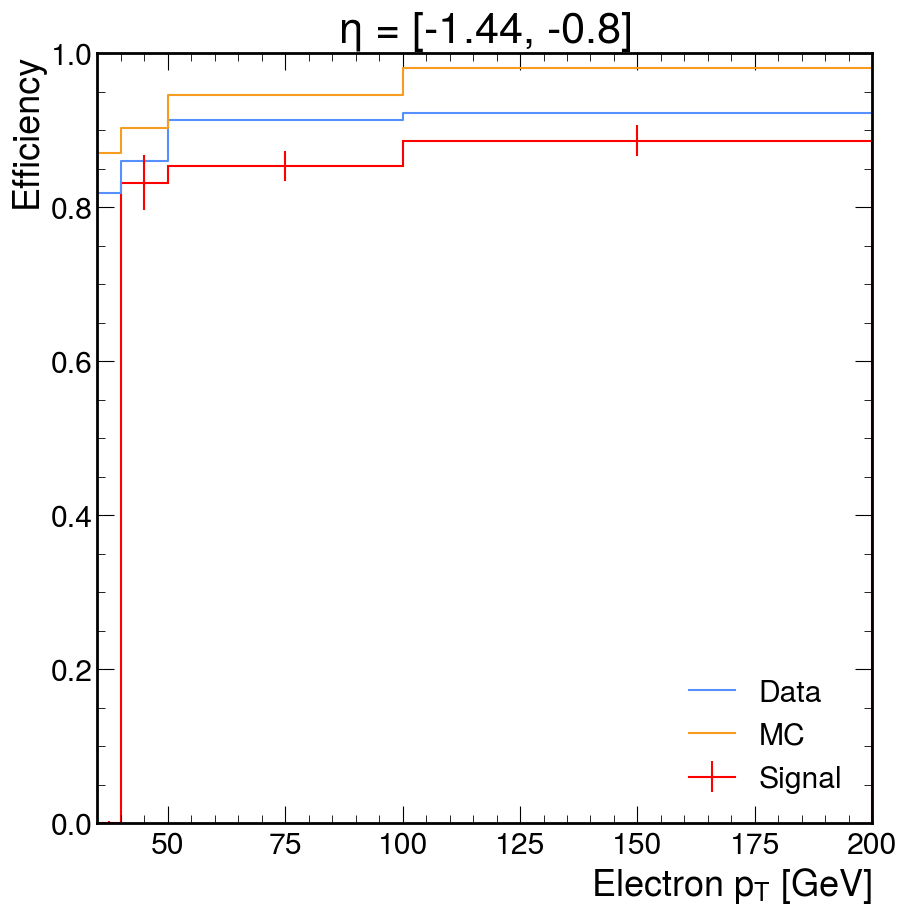

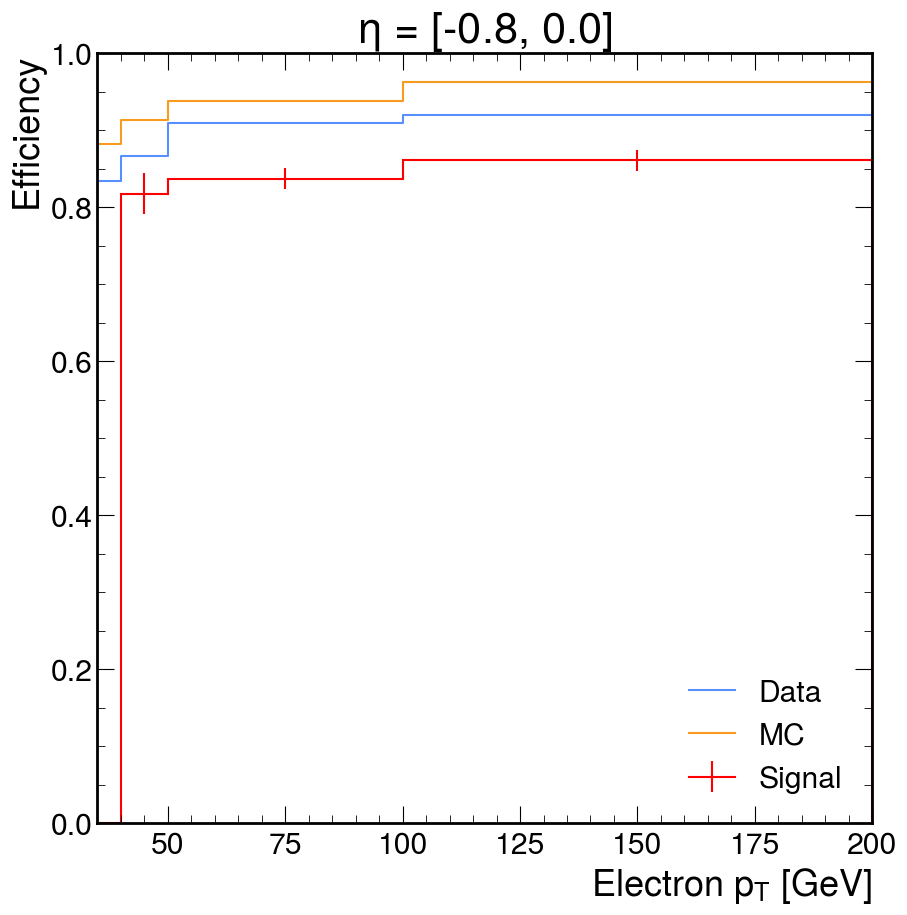

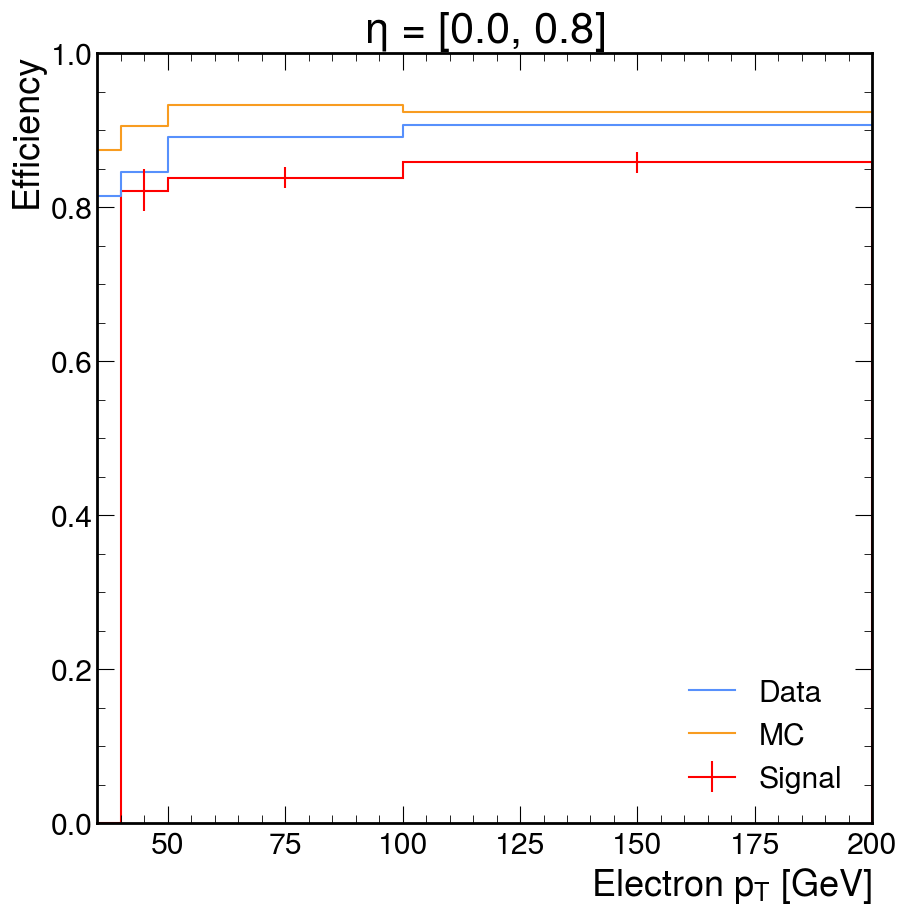

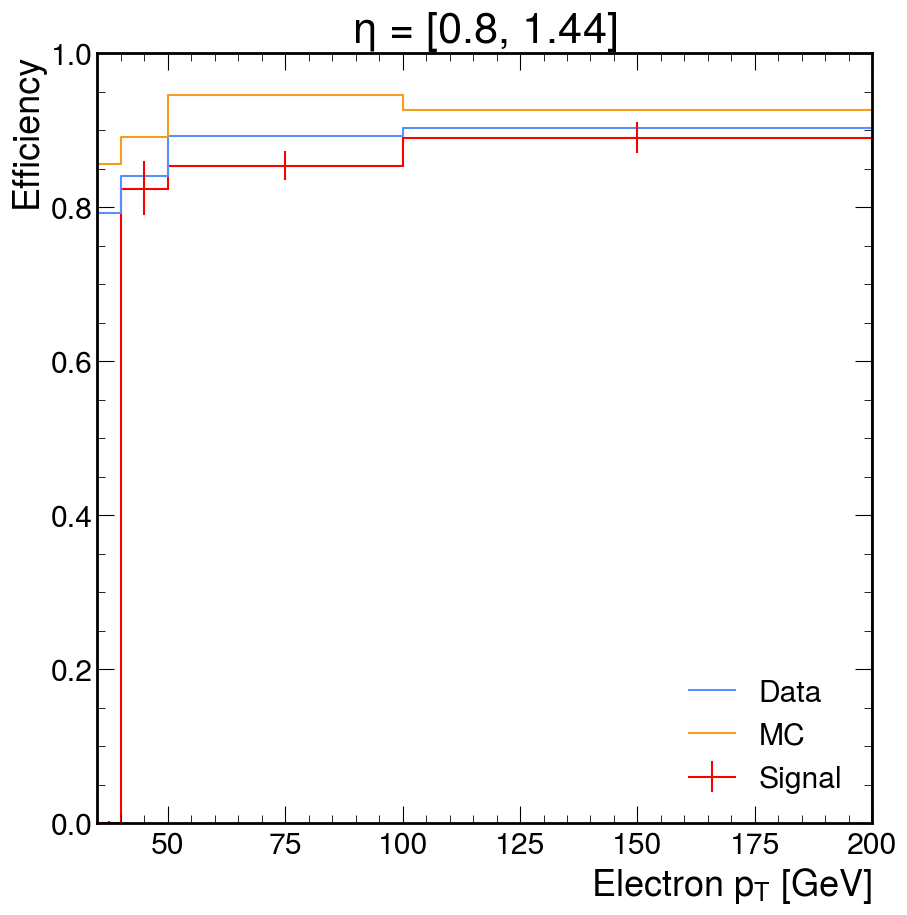

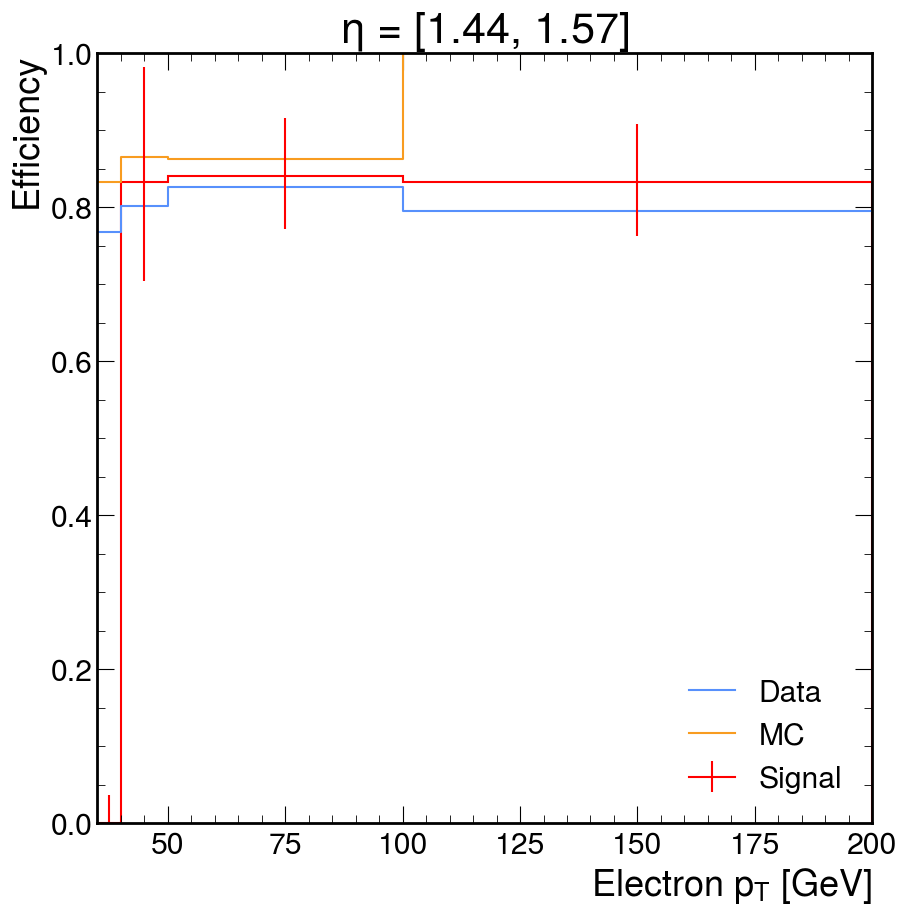

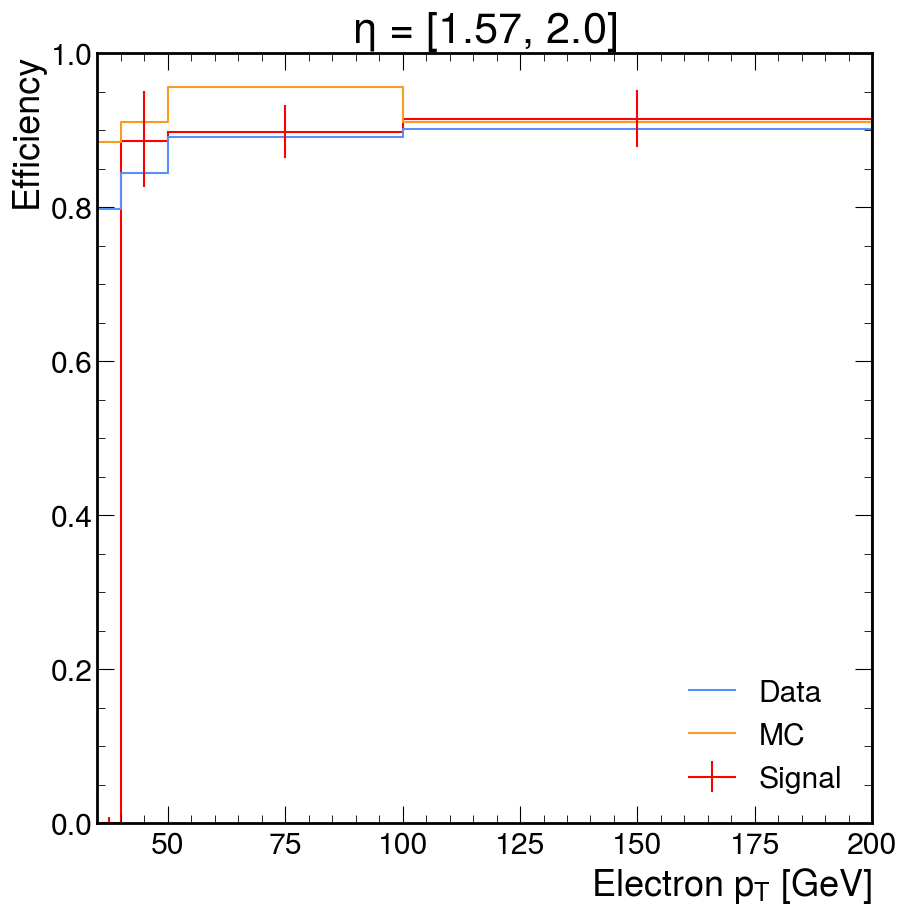

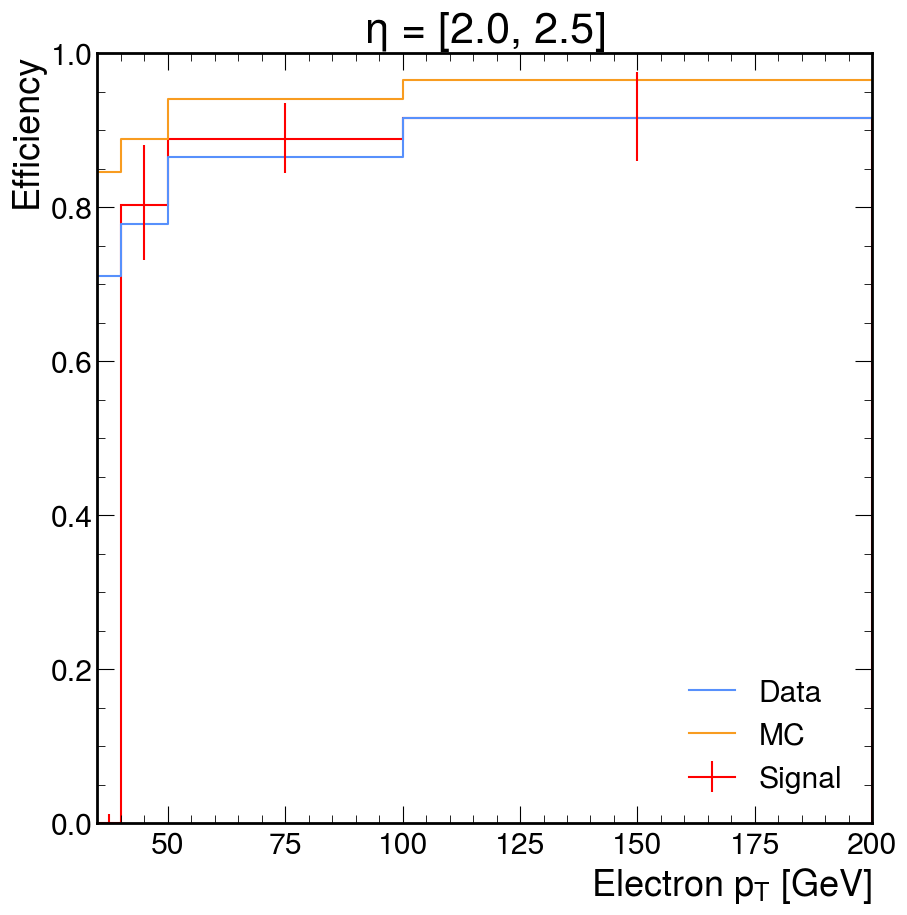

In [14]:
for n in range(0, 10):
    fig, ax = plt.subplots()

    hlt_sf1 = hlt_sf_data[n:n+1, 0:6]
    hlt_sf2 = hlt_sf_mc[n:n+1, 0:6]

    hlt_sf1 = hlt_sf1.to_numpy()
    hlt_sf2 = hlt_sf2.to_numpy()

    frq1, edges1 = hlt_sf1[0][0], hlt_sf1[2]
    frq2, edges2 = hlt_sf2[0][0], hlt_sf2[2]

    ax.step(edges1[:-1], frq1, label=f"Data")
    ax.step(edges2[:-1], frq2, label=f"MC")

    hep.histplot(get_sig_hist(df, round(hlt_sf1[1][0], 2), round(hlt_sf1[1][1], 2)), ax=ax, histtype="step", color="red", label="Signal")

    ax.set_ylim(0, 1)
    ax.set_xlim(35, 200)
    ax.set_xlabel(r"Electron $p_T$ [GeV]")
    ax.set_ylabel("Efficiency")

    ax.set_title(rf"$\eta$ = [{round(hlt_sf1[1][0], 2)}, {round(hlt_sf1[1][1], 2)}]")

    ax.legend()
    plt.savefig(f"/home/users/aaarora/public_html/vbs/plots/trigger/2017/hlt_{n}.png")

In [ ]:
with uproot.open("/ceph/cms/store/user/aaarora/VBS_1lep_skims/data_1lep_4ak4_or_1ak8_2ak4_v1/RunIISummer20UL16NanoAODAPVv9/VBSWZH_MJJ-100_4f_TuneCP5_13TeV-madgraph-pythia8/NANOAODSIM/106X_mcRun2_asymptotic_preVFP_v11-v2/4000/skimmed/output_merged2.root") as f:
    df = f.get("Events").arrays(["Jet_genJetIdx"], library="pd")    

In [35]:
df = r.RDataFrame("Events", "/data/userdata/aaarora/E5D40CC6-421E-4D4F-B994-86EE04118865.root")

In [ ]:
r.gInterpreter.Declare("""
ROOT::VecOps::RVec<float> Electron_E(const ROOT::VecOps::RVec<float>& pt, const ROOT::VecOps::RVec<float>& eta, const ROOT::VecOps::RVec<float>& phi, const ROOT::VecOps::RVec<float>& mass) {
    ROOT::VecOps::RVec<float> E;
    for (int i = 0; i < pt.size(); i++) {
        E.push_back(TLorentzVector(pt[i], eta[i], phi[i], mass[i]).E());
    }
    return E;
}
""")

In [36]:
df = df.Define("Electron_E", "Electron_E(Electron_pt, Electron_eta, Electron_phi, Electron_mass)")
df = df.Define("BadElec", "Sum(Electron_E <= 0 && abs(Electron_eta) > 1.5 && abs(Electron_eta) < 2.5 && Electron_r9 > 0.98)")
df = df.Define("GoodElec", "Sum(Electron_E > 0 && abs(Electron_eta) > 1.5 && abs(Electron_eta) < 2.5 && Electron_r9 > 0.98)")

df = df.Define("BadElecOut", "Sum(Electron_E <= 0)")
df = df.Define("GoodElecOut", "Sum(Electron_E > 0)")

nbad = df.Sum("BadElec").GetValue()
ngood = df.Sum("GoodElec").GetValue()
nbadout = df.Sum("BadElecOut").GetValue()
ngoodout = df.Sum("GoodElecOut").GetValue()

In [ ]:
nbad / (nbad + ngood)

In [ ]:
nbadout / (nbadout + ngoodout)